# SkimLit - PubMed 200K RCT

## Introduction

### Checking the GPU

In [1]:
# # Google Colab / Systems with NVIDIA GPU
# !nvidia-smi

### Install / Import Tensorflow

In [2]:
# # Uncomment if does not exist to install TensorFlow.
# !pip install tensorflow

### Import basic libraries

In [3]:
# Ignores warnings if continuously showed up.
import warnings
warnings.filterwarnings(action = "ignore")

# Imports common libraries.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os, io, platform, subprocess
import time, datetime, random, itertools
import string

from importlib import reload

### Import core tensorflow library and related modules

In [4]:
import tensorflow as tf
import tensorflow_hub as hub
import tf_keras

In [5]:
print(tf.__version__)

2.19.0


### Getting helper functions

In [6]:
import extras.helper_functions as hf
from importlib import reload
reload(hf)

<module 'extras.helper_functions' from 'D:\\Desktop\\Projects\\Temporal Project\\extras\\helper_functions.py'>

## Main Section

### Getting Data

Main Source of case study | PubMed 200K RCT (Randomized Controlled Trials)
> https://arxiv.org/abs/1710.06071

One of the sources could found a dataset for this case is the following: 
> https://github.com/Franck-Dernoncourt/pubmed-rct

In [7]:
if not os.path.exists("pubmed-rct"):
    warnings.filterwarnings("ignore", category = ResourceWarning)
    subprocess.run(["git", "clone", "https://github.com/Franck-Dernoncourt/pubmed-rct"], check=True)

if platform.system() == "Windows":
    print("----------")
    !dir pubmed-rct
    print("----------")    
else:
    print("**********")
    !ls pubmed-rct
    print("**********")    

----------
 Volume in drive D is Storage
 Volume Serial Number is 12EE-8809

 Directory of D:\Desktop\Projects\Temporal Project\pubmed-rct

08/05/2025  10:05    <DIR>          .
12/05/2025  14:30    <DIR>          ..
08/05/2025  10:05    <DIR>          PubMed_200k_RCT
08/05/2025  10:05    <DIR>          PubMed_200k_RCT_numbers_replaced_with_at_sign
08/05/2025  10:05    <DIR>          PubMed_20k_RCT
08/05/2025  10:05    <DIR>          PubMed_20k_RCT_numbers_replaced_with_at_sign
08/05/2025  10:05             3.733 README.md
               1 File(s)          3.733 bytes
               6 Dir(s)  1.044.077.453.312 bytes free
----------


In [8]:
# Checking what files are in the 'PubMed_20K' dataset.
if platform.system() == "Windows":
    print("----------")
    !dir pubmed-rct\\PubMed_20k_RCT_numbers_replaced_with_at_sign
    print("----------")
else:
    print("**********")
    !ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign
    print("**********")

----------
 Volume in drive D is Storage
 Volume Serial Number is 12EE-8809

 Directory of D:\Desktop\Projects\Temporal Project\pubmed-rct\PubMed_20k_RCT_numbers_replaced_with_at_sign

08/05/2025  10:05    <DIR>          .
08/05/2025  10:05    <DIR>          ..
08/05/2025  10:05         4.880.409 dev.txt
08/05/2025  10:05         4.846.504 test.txt
08/05/2025  10:05        29.118.832 train.txt
               3 File(s)     38.845.745 bytes
               2 Dir(s)  1.044.077.453.312 bytes free
----------


In [9]:
# Starting expirements using 20K dataset with numbers replaced with '@' sign.
data_dir = "pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [10]:
# Checking all of the filenames in the target directory.
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt']

### Preprocessing data

In [11]:
# Reading the training lines.
train_lines = hf.get_lines(data_dir + "train.txt") # read the lines with the training file
train_lines[:20]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [12]:
len(train_lines)

210040

In [13]:
# Getting data from file and preprocessing it.
start_time = time.time()

train_samples = hf.preprocess_text_with_line_numbers(data_dir + "train.txt") # training data
val_samples = hf.preprocess_text_with_line_numbers(data_dir + "dev.txt") # validation data
test_samples = hf.preprocess_text_with_line_numbers(data_dir + "test.txt") # testing data
print(len(train_samples), len(val_samples), len(test_samples))

end_time = time.time()
print(f"Execution time: {end_time - start_time:.4f} seconds")

180040 30212 30135
Execution time: 0.4960 seconds


In [14]:
# Checking the first abstravt of our training data.
train_samples[:10]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western ontari

In [15]:
# Turning the data from dictionaries into DataFrames.
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)

train_df.head(10)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


In [16]:
# Distribution of labels in training dataset.
train_df.target.value_counts()

target
METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: count, dtype: int64

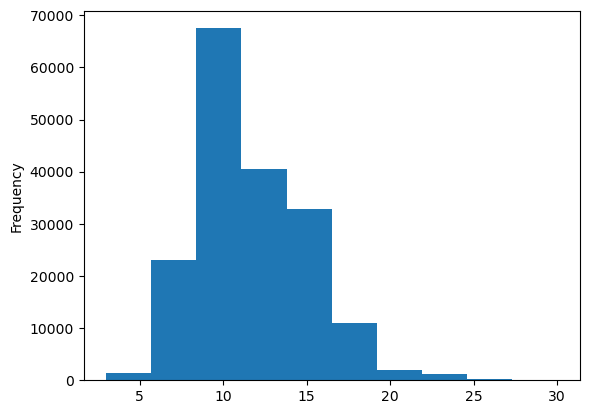

In [17]:
# Checking the length of different lines
train_df.total_lines.plot.hist();

### Get lists of sentences

In [18]:
# Converting abstract text lines into lists
train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()
print(len(train_sentences), len(val_sentences), len(test_sentences))

180040 30212 30135


In [19]:
# View the first lines of sentences
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

### Making numerical labels (ML models required numeric labels)

In [20]:
# One hot encoding lables.
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse_output = False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1, 1))

# Checking what one hot encoder labels look like.
train_labels_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

### Labeling above encoding labels

In [21]:
# Extracting labels ("targets" columns) and encode them into integers
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
train_labels_encoded = le.fit_transform(train_df["target"].to_numpy().reshape(-1, 1))
val_labels_encoded = le.transform(val_df["target"].to_numpy().reshape(-1, 1))
test_labels_encoded = le.fit_transform(test_df["target"].to_numpy().reshape(-1, 1))

train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [22]:
# Getting class names and number of classes from LabelEncoder instance
num_classes = len(le.classes_)
class_names = le.classes_
print(f"Number of Classes: {num_classes}\nClass Names: {class_names}")

Number of Classes: 5
Class Names: ['BACKGROUND' 'CONCLUSIONS' 'METHODS' 'OBJECTIVE' 'RESULTS']


## Starting Modeling Experiments

### Model 0: Naive Bayes with TF-IDF encoder (Baseline)

In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Creates tokenization and modeling pipeline.
model_0 = Pipeline([
    ("tfidf", TfidfVectorizer()), # converts words to numbers using tfidf
    ("clf", MultinomialNB()) # model the text
])

# Fits the pipeline to the training data.
model_0.fit(train_sentences, train_labels_encoded)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [24]:
# Evaluating baseline model on Validation dataset.
baseline_score = model_0.score(val_sentences, val_labels_encoded)
print(f"Our baseline model achieves an accuracy of: {baseline_score*100:.2f}%")

Our baseline model achieves an accuracy of: 72.18%


In [25]:
# Making some prediction using test dataset.
baseline_preds = model_0.predict(val_sentences)

In [26]:
baseline_results = hf.calculate_results(y_true = val_labels_encoded,
                                        y_pred = baseline_preds)
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

### Text Vectorization (tokenization)

In [27]:
# Uses the default TextVectorization prameters.
text_vectorizer = tf.keras.layers.TextVectorization(max_tokens = None, # how many words in the vocabulary (automatically add <OOV>).
                                                    standardize = "lower_and_strip_punctuation", # how to process text.
                                                    split = "whitespace", # how to split tokens.
                                                    ngrams = None, # creates groups of n-words?
                                                    output_mode = "int", # how to map tokens to numbers.
                                                    output_sequence_length = None) # how long should the output sequence of tokens be?
                                                    # pad_to_max_tokens = True) # Not valid if using max_tokens = None.

# Finds the average number of tokens (words) in the training tweets.
num_of_words_per_sentence = [len(i.split()) for i in train_sentences]
avg_words = round(sum(num_of_words_per_sentence) / len(train_sentences))
avg_words

26

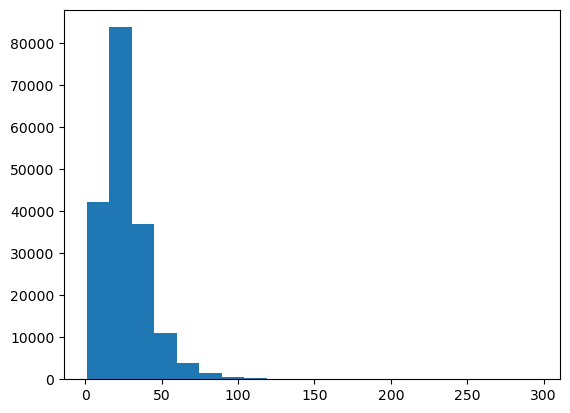

In [28]:
# Checking the distribution of words per sentence looks like.

plt.hist(num_of_words_per_sentence, bins = 20);

In [29]:
# Looking for the best number of words, covering the most amount of sentences, particularly for the 95% of all sentences.
best_num_of_words_per_sentence = int(np.percentile(num_of_words_per_sentence, 95))
best_num_of_words_per_sentence

55

In [30]:
max_vocab_length = 68000 # max number of words to have in our vocabulary

In [31]:
# Setting up vectorization variables.
max_length = best_num_of_words_per_sentence # max length our sequences will be (e.g. how many words from a Tweet does our model see?)

text_vectorizer = tf.keras.layers.TextVectorization(max_tokens = None,
                                                    output_mode = "int", 
                                                    output_sequence_length = max_length)

In [32]:
# Fits the text vectorizer to the training text.
text_vectorizer.adapt(train_sentences)

AttributeError: module 'ml_dtypes' has no attribute 'float4_e2m1fn'


> #### If we want to specify the "max_tokens" parameter of TextVectorization(), and we have not a note for length of vocabulary, firstly we setting the "max_tokens = None", which means we getting all the existing words.
> #### After that we run the following line, which informs us for the amount of words, and if we decide to specify the max_tokens (most common words), we replace the "None" value with the preferable number of words.

In [33]:
# Gets all of the unique words in our training data.
words_in_vocab = text_vectorizer.get_vocabulary()

In [34]:
# Creates sample sentence and tokenize it.
sample_sentence = "This is a sample sentence for a model we build!"
text_vectorizer([sample_sentence])

<tf.Tensor: shape=(1, 55), dtype=int64, numpy=
array([[   23,    20,     8,   441,  9848,    11,     8,   314,    43,
        10055,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int64)>

In [35]:
# Chooses random sentence from the training dataset and tokenized it.
random_sentence = random.choice(train_sentences)
print(f"Original text: \n{random_sentence}{2*'\n'}Vectorized version:")
text_vectorizer([random_sentence])

Original text: 
estimated effects of breast-feeding on childhood health vary between studies , possibly due to confounding by baseline maternal and child characteristics .

Vectorized version:


<tf.Tensor: shape=(1, 55), dtype=int64, numpy=
array([[ 597,   71,    4, 1578,   18, 1527,   97, 3712,   30,  202, 2192,
         434,    6, 4911,   22,   49,  823,    3,  734,  395,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0]],
      dtype=int64)>

In [36]:
# Getting the unique words in vocabulary.
top_10_words = words_in_vocab[:10] # gets the most common words
bottom_10_words = words_in_vocab[-10:] # gets the least common words
print(f"Number of words in vocabulary: {len(words_in_vocab)}")
print(f"10 Most common words: {top_10_words}")
print(f"10 Least common words: {bottom_10_words}")

Number of words in vocabulary: 64841
10 Most common words: ['', '[UNK]', 'the', 'and', 'of', 'in', 'to', 'with', 'a', 'were']
10 Least common words: ['aarm', 'aaqol', 'aaq', 'aanhui', 'aana', 'aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


### Creating an Embedding using Embedding Layer

In [37]:
embedding = tf.keras.layers.Embedding(input_dim = len(words_in_vocab), # length of vocabulary / setting the input shape
                                      # input_dim = max_vocab_length, # length of vocabulary / setting the input shape
                                      output_dim = 128, # setting the output shappe
                                      mask_zero = True, # uses masking to handle variable sequence length (save space), better efficient computing basically. 
                                      # embeddings_initializer = tf.keras.initializers.RandomUniform(),
                                      name = "embedding_1")

In [38]:
# Getting a random sentence from the training set.
random_sentence = random.choice(train_sentences)
print(f"Original text: \n{random_sentence}{2*'\n'}")
# Vectorization of random sentence.
vect_sent = text_vectorizer([random_sentence])
print(f"Vectorized text: \n{vect_sent}{2*'\n'}")
# Embedes the random sentence (turn it into numerical representation).
embed_sent = embedding(vect_sent)
print(f"Embedded text: \n{embed_sent}{2*'\n'}")
print(f"Shape of tensor from embedded text: {embed_sent.shape}")

Original text: 
however , its use in patients with lt and hepatitis c ( hcv ) is controversial .


Vectorized text: 
[[ 140  308   87    5   12    7 4580    3 1363  243 1446   20 3085    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]


Embedded text: 
[[[-0.02179405 -0.04357599  0.01537145 ... -0.04679033 -0.04159679
    0.02443798]
  [ 0.01927758 -0.04133111 -0.03351287 ... -0.02258699  0.01176351
   -0.01256771]
  [ 0.02606765  0.04039546 -0.01481049 ...  0.04098851 -0.03745676
   -0.0190774 ]
  ...
  [-0.02062271  0.0208516  -0.00437102 ...  0.04133955  0.0082278
    0.01562222]
  [-0.02062271  0.0208516  -0.00437102 ...  0.04133955  0.0082278
    0.01562222]
  [-0.02062271  0.0208516  -0.00437102 ...  0.04133955  0.0082278
    0.01562222]]]


Shape of tensor from embedded text: (1, 55, 128)


### Creates datasets (as fast as possible)

> #### https://www.tensorflow.org/guide/data_performance
> #### https://www.tensorflow.org/guide/data

In [39]:
# Turning data into Tensorflow Datasets.
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

train_dataset

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [40]:
# Taking the TensorSliceDatasets' and turn them into prefected datasets
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

### Model 1: Conv1D with token embeddings

In [41]:
# Creating model architecture.
inputs = tf.keras.layers.Input(shape = (1, ), dtype = tf.string)
text_vectors = text_vectorizer(inputs) # vectorizes text inputs
token_embeddings = embedding(text_vectors) # creates embedding
x = tf.keras.layers.Conv1D(filters = 64, kernel_size = 5, padding = "same", activation = "relu")(token_embeddings)
x = tf.keras.layers.GlobalAveragePooling1D()(x) # condense the output of out feature vector from conv layer.
outputs = tf.keras.layers.Dense(num_classes, activation = "softmax")(x)
model_1 = tf.keras.Model(inputs, outputs)

In [42]:
# Compiling model.
model_1.compile(loss = "categorical_crossentropy", 
                optimizer = tf.keras.optimizers.Adam(), 
                metrics = ["accuracy"])

In [43]:
model_1.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ text_vectorization_1            │ (None, 55)             │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_1 (Embedding)         │ (None, 55, 128)        │     8,299,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 55, 64)         │        41,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,340,997 (31.82 MB)

 Trainable params: 8,340,997 (31.82 MB)

 Non-trainable params: 0 (0.00 B)

In [44]:
# Fits model on training data.
history_model_1 = model_1.fit(train_dataset, 
                              steps_per_epoch= int(0.1 * len(train_dataset)),
                              epochs = 3, 
                              validation_data = valid_dataset, 
                              validation_steps = int(0.1 * len(valid_dataset)))

Epoch 1/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 22s 37ms/step - accuracy: 0.5224 - loss: 1.1708 - val_accuracy: 0.7384 - val_loss: 0.6902
Epoch 2/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 21s 37ms/step - accuracy: 0.7460 - loss: 0.6843 - val_accuracy: 0.7699 - val_loss: 0.6351
Epoch 3/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 21s 37ms/step - accuracy: 0.7734 - loss: 0.6191 - val_accuracy: 0.7856 - val_loss: 0.5967


In [45]:
# Evaluates on whole validation dataset.
model_1.evaluate(valid_dataset)

945/945 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7869 - loss: 0.5932


[0.5944694876670837, 0.787534773349762]

In [46]:
# Makes prediction using model_1 (the outputs are tensors of propabilities, the highest prob of tensor represents the output category model predicted as correct for sentence)
model_1_pred_probs = model_1.predict(valid_dataset)
model_1_pred_probs, model_1_pred_probs.shape

945/945 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


(array([[4.7499126e-01, 1.4720753e-01, 7.6392740e-02, 2.7580699e-01,
         2.5601473e-02],
        [4.0903386e-01, 3.3415800e-01, 1.1288385e-02, 2.3416816e-01,
         1.1351572e-02],
        [1.4589012e-01, 7.9259537e-03, 2.2073926e-03, 8.4394318e-01,
         3.3357232e-05],
        ...,
        [1.0408394e-05, 7.3351688e-04, 6.7836244e-04, 5.7935194e-06,
         9.9857187e-01],
        [4.6393391e-02, 4.5053673e-01, 8.5427165e-02, 4.6632368e-02,
         3.7101030e-01],
        [1.6089329e-01, 7.0552844e-01, 5.8616918e-02, 3.8660374e-02,
         3.6300980e-02]], dtype=float32),
 (30212, 5))

In [47]:
# Converting predictions' propabilietes to classes.
model_1_preds = tf.argmax(model_1_pred_probs, axis = 1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1], dtype=int64)>

In [48]:
# Calculating model_1 results.
model_1_results = hf.calculate_results(y_true = val_labels_encoded,
                                       y_pred = model_1_preds)
model_1_results

{'accuracy': 78.75347544022243,
 'precision': 0.7839516080001568,
 'recall': 0.7875347544022243,
 'f1': 0.7851509111723519}

In [49]:
# Compares the baseline model against to model_1.
hf.compare_baseline_to_new_model_results(baseline_results, model_1_results)

The "accuracy" of new model '78.75', is BETTER than baseline's '72.18' => 6.57.

The "precision" of new model '0.78', is BETTER than baseline's '0.72' => 0.07.

The "recall" of new model '0.79', is BETTER than baseline's '0.72' => 0.07.

The "f1" of new model '0.79', is BETTER than baseline's '0.70' => 0.09.



### Model 2: Feature extraction with pretrained token embeddings

In [50]:
# Download pretrained TensorFlow Hub USE.
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable = False, # all layers from pretrained model are not trainable. 
                                        name = "universal_sentence_encoder");

In [51]:
# Test out the pretrained embedding on a random sentence.
random_train_sentence = random.choice(train_sentences)
print(f"Random sentence:\n {random_train_sentence}")
use_embedded_sentence = tf_hub_embedding_layer([random_train_sentence])
print(f"Sentence after embedding:\n{use_embedded_sentence[0][:30]} (truncated output)...\n")
print(f"Length of sentence embedding: {len(use_embedded_sentence[0])}")

Random sentence:
 future investigations will be needed to determine the full effects of the imagine health intervention on insulin resistance , stress , and stress biomarkers .



Sentence after embedding:
[ 0.0150422  -0.00378146 -0.02286663  0.05801295 -0.02211573 -0.06511374
  0.05790316  0.03724584  0.03986306  0.01013728  0.08870746  0.00226341
  0.0526503  -0.00449469  0.00757888 -0.0521353  -0.09305993  0.0497514
 -0.05966    -0.03693961  0.03445817  0.0272451   0.03331577 -0.04079922
  0.01705352  0.01628705  0.02492375  0.03627333  0.01535322 -0.00400048] (truncated output)...

Length of sentence embedding: 512


In [52]:
# Building feature extraction model
inputs = tf_keras.layers.Input(shape = [], dtype = tf.string) # shape needs to be "list", so we use empty [] as shape
pretrained_embedding = tf_hub_embedding_layer(inputs)
x = tf_keras.layers.Dense(128, activation = "relu")(pretrained_embedding)
outputs = tf_keras.layers.Dense(num_classes, activation = "softmax")(x)
model_2 = tf_keras.Model(inputs = inputs, outputs = outputs, name = "model_2_USE_feature_extraction")

In [53]:
# Compiles model.
model_2.compile(loss = "categorical_crossentropy", 
                optimizer = tf_keras.optimizers.Adam(), 
                metrics = ["accuracy"])

In [54]:
model_2.summary()

Model: "model_2_USE_feature_extraction"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None,)]                 0         
                                                                 
 universal_sentence_encoder  (None, 512)               256797824 
  (KerasLayer)                                                   
                                                                 
 dense (Dense)               (None, 128)               65664     
                                                                 
 dense_1 (Dense)             (None, 5)                 645       
                                                                 
Total params: 256864133 (979.86 MB)
Trainable params: 66309 (259.02 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


In [55]:
# Fits model.
history_model_2 = model_2.fit(train_dataset, 
                              steps_per_epoch= int(0.1 * len(train_dataset)),
                              epochs = 3, 
                              validation_data = valid_dataset, 
                              validation_steps = int(0.1 * len(valid_dataset)))

Epoch 1/3



562/562 [==============================] - 5s 6ms/step - loss: 0.9143 - accuracy: 0.6534 - val_loss: 0.7956 - val_accuracy: 0.6922
Epoch 2/3
562/562 [==============================] - 3s 6ms/step - loss: 0.7678 - accuracy: 0.7038 - val_loss: 0.7538 - val_accuracy: 0.7071
Epoch 3/3
562/562 [==============================] - 3s 6ms/step - loss: 0.7531 - accuracy: 0.7110 - val_loss: 0.7410 - val_accuracy: 0.7128


In [56]:
# Evaluates on whole validation dataset.
model_2.evaluate(valid_dataset)

945/945 [==============================] - 4s 4ms/step - loss: 0.7431 - accuracy: 0.7131


[0.7430889010429382, 0.7130610346794128]

In [57]:
model_2_pred_probs = model_2.predict(valid_dataset)
model_2_pred_probs, model_2_pred_probs.shape

945/945 [==============================] - 5s 5ms/step


(array([[4.3194956e-01, 3.6423898e-01, 2.1388459e-03, 1.9495788e-01,
         6.7147873e-03],
        [3.3777741e-01, 4.9716905e-01, 3.7470853e-03, 1.5843405e-01,
         2.8724587e-03],
        [2.2997291e-01, 1.3279866e-01, 1.9255748e-02, 5.7908714e-01,
         3.8885556e-02],
        ...,
        [1.8327523e-03, 6.9361841e-03, 5.1594201e-02, 8.5863366e-04,
         9.3877816e-01],
        [3.9717639e-03, 4.8536345e-02, 1.9346155e-01, 1.4467982e-03,
         7.5258350e-01],
        [1.6870518e-01, 2.3045452e-01, 5.2717823e-01, 9.0480475e-03,
         6.4614050e-02]], dtype=float32),
 (30212, 5))

In [58]:
# Converting predictions' propabilietes to classes.
model_2_preds = tf.argmax(model_2_pred_probs, axis = 1)
model_2_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 2], dtype=int64)>

In [59]:
# Calculating model_2 results.
model_2_results = hf.calculate_results(y_true = val_labels_encoded,
                                       y_pred = model_1_preds)
model_2_results

{'accuracy': 78.75347544022243,
 'precision': 0.7839516080001568,
 'recall': 0.7875347544022243,
 'f1': 0.7851509111723519}

In [60]:
# Compares the baseline model against to model_2.
hf.compare_baseline_to_new_model_results(baseline_results, model_2_results)

The "accuracy" of new model '78.75', is BETTER than baseline's '72.18' => 6.57.

The "precision" of new model '0.78', is BETTER than baseline's '0.72' => 0.07.

The "recall" of new model '0.79', is BETTER than baseline's '0.72' => 0.07.

The "f1" of new model '0.79', is BETTER than baseline's '0.70' => 0.09.



### Model 3: Conv1D with characters embeddings

#### Creating Character-Level tokenizer

In [61]:
# Making function to split sentences into characters.
def split_chars(text):
    return " ".join(list(text))

In [62]:
# Text splitting non-character-level sequence into characters.
split_chars(random_train_sentence)

'f u t u r e   i n v e s t i g a t i o n s   w i l l   b e   n e e d e d   t o   d e t e r m i n e   t h e   f u l l   e f f e c t s   o f   t h e   i m a g i n e   h e a l t h   i n t e r v e n t i o n   o n   i n s u l i n   r e s i s t a n c e   ,   s t r e s s   ,   a n d   s t r e s s   b i o m a r k e r s   .'

In [63]:
# Split sequence-level data splits into charaters-level data splits.
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]

train_chars[:5]

['t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .',
 'a   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   o a   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .',
 'o u t c o m e   m e a s u r e s   i n c l u d e d   p a i n   r e d u c t i o n   a n d   i m p r o v e m e n t   i n   f u n c t i o n   s c o r e s   a 

In [64]:
# Getting the average character length, such as before with words per sentence.
char_lens = [len(sentense) for sentense in train_sentences]
mean_char_len_per_sentence = round(np.mean(char_lens))
mean_char_len_per_sentence

149

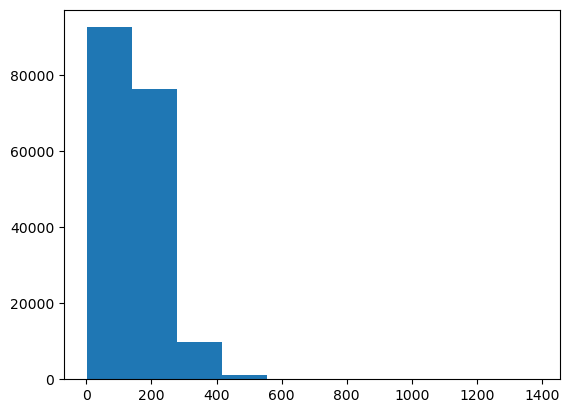

In [65]:
# Checking the distribution of sentences at a character-level.
plt.hist(char_lens, bins = 10);

In [66]:
# Looking for the best number of characters, covering the most amount of sentences, particularly for the 95% of all sentences.
best_num_of_chars_per_sentence = int(np.percentile(char_lens, 95))
best_num_of_chars_per_sentence

290

In [67]:
# Get all keyboard charactes.
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [68]:
# Creating char-level token vectorizer instance
NUM_CHAR_TOKENS = len(alphabet) + 2 # adding 2 for 'space' and 'OOV' token (OVV = Out Of Vocabulary)
char_vectorizer = tf.keras.layers.TextVectorization(max_tokens = NUM_CHAR_TOKENS, 
                                                    output_sequence_length = best_num_of_chars_per_sentence,
                                                    # standardize = None, # If line is enabled, then punctuation symbols will be included
                                                    name = "char_vectorizer")

In [69]:
# Adapting character vectorizer to training character.
char_vectorizer.adapt(train_chars)

In [70]:
# Checking vocab stats.
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of different characters in character vocal: {len(char_vocab)}")
print(f"5 most common characters: {char_vocab[:5]}")
print(f"5 least common characters: {char_vocab[-5:]}")

Number of different characters in character vocal: 28
5 most common characters: ['', '[UNK]', 'e', 't', 'i']
5 least common characters: ['k', 'x', 'z', 'q', 'j']


In [71]:
# Testing out character vectorizer.
random_train_chars = random.choice(train_chars)
print(f"Charified text:\n{random_train_chars}{2*'\n'}")
print(f"Length of random_train_sentence: {len(random_train_chars.split())}{2*'\n'}")
vectorized_chars = char_vectorizer([random_train_chars])
print(f"Vectorized chars:\n{vectorized_chars}{2*'\n'}")
print(f"Length of vectorized_chars: {len(vectorized_chars[0])}{2*'\n'}")

Charified text:
p a r t i c i p a n t s   w e r e   @   c h i l d r e n   w i t h   a   h i s t o r y   o f   i n s t i t u t i o n a l   c a r e   a n d   @   n e v e r - i n s t i t u t i o n a l i z e d   c o n t r o l   (   n i g   )   s u b j e c t s   e n r o l l e d   i n   a   r a n d o m i z e d   c o n t r o l l e d   t r i a l   o f   f o s t e r   c a r e   f o r   i n s t i t u t i o n a l   c a r e   ,   a s s e s s e d   f r o m   t o d d l e r h o o d   t o   @   m o n t h s   .


Length of random_train_sentence: 205


Vectorized chars:
[[14  5  8  3  4 11  4 14  5  6  3  9 20  2  8  2 11 13  4 12 10  8  2  6
  20  4  3 13  5 13  4  9  3  7  8 19  7 17  4  6  9  3  4  3 16  3  4  7
   6  5 12 11  5  8  2  5  6 10  6  2 21  2  8  4  6  9  3  4  3 16  3  4
   7  6  5 12  4 25  2 10 11  7  6  3  8  7 12  6  4 18  9 16 22 27  2 11
   3  9  2  6  8  7 12 12  2 10  4  6  5  8  5  6 10  7 15  4 25  2 10 11
   7  6  3  8  7 12 12  2 10  3  8  4  5 12  7 17 17  7  9  3  2  8 11 

#### Creating a character-level embedding

In [72]:
# Creates char embedding layer.
char_embed = tf.keras.layers.Embedding(input_dim = len(char_vocab),
                                       output_dim = 25,
                                       mask_zero = True,
                                       name = "char_embed")

In [73]:
# Testing out character embedding layer.
print(f"Charified text:\n {random_train_chars}\n")
char_embed_example = char_embed(char_vectorizer([random_train_chars]))
print(f"Embedded chars. (after vectorization and embedding):\n {char_embed_example}\n")
print(f"Character embedding shape: {char_embed_example.shape}\n")

Charified text:
 p a r t i c i p a n t s   w e r e   @   c h i l d r e n   w i t h   a   h i s t o r y   o f   i n s t i t u t i o n a l   c a r e   a n d   @   n e v e r - i n s t i t u t i o n a l i z e d   c o n t r o l   (   n i g   )   s u b j e c t s   e n r o l l e d   i n   a   r a n d o m i z e d   c o n t r o l l e d   t r i a l   o f   f o s t e r   c a r e   f o r   i n s t i t u t i o n a l   c a r e   ,   a s s e s s e d   f r o m   t o d d l e r h o o d   t o   @   m o n t h s   .

Embedded chars. (after vectorization and embedding):
 [[[-0.01199689  0.04127277  0.02966363 ...  0.04383874  0.02410899
    0.03254404]
  [ 0.02299479  0.04426409 -0.01949729 ... -0.00995899  0.00319308
    0.04074471]
  [-0.02903069  0.0310604   0.0382886  ...  0.04298231  0.04105951
    0.04591239]
  ...
  [ 0.00616181  0.01627037  0.0265903  ... -0.04725432  0.03643944
   -0.04915544]
  [ 0.00616181  0.01627037  0.0265903  ... -0.04725432  0.03643944
   -0.04915544]
  [ 0.00616181  0.01627

#### Building character-level embedding model

In [74]:
# Making Conv1D on chars only.
inputs = tf.keras.layers.Input(shape = (1, ), dtype = tf.string)
char_vectors = char_vectorizer(inputs)
char_embeddings = char_embed(char_vectors)
x = tf.keras.layers.Conv1D(64, kernel_size = 5, padding = "same", activation = "relu")(char_embeddings)
# In case "GlobalAveragePooling" does not give good results, try to change to "GlobalMaxPooling"
x = tf.keras.layers.GlobalMaxPooling1D()(x)
outputs = tf.keras.layers.Dense(num_classes, activation = "softmax")(x)
model_3 = tf.keras.Model(inputs = inputs, outputs = outputs, name = "model_3_conv1d_char_embeddings")

In [75]:
# Compiles model.
model_3.compile(loss = "categorical_crossentropy", 
                optimizer = tf.keras.optimizers.Adam(), 
                metrics = ["accuracy"])

In [76]:
model_3.summary()

Model: "model_3_conv1d_char_embeddings"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ char_vectorizer                 │ (None, 290)            │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ char_embed (Embedding)          │ (None, 290, 25)        │           700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 290, 64)        │         8,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 64)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,089 (35.50 KB)

 Trainable params: 9,089 (35.50 KB)

 Non-trainable params: 0 (0.00 B)

#### Turning data into Tensorflow Datasets to allow fitting of model run faster

In [77]:
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
valid_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset = tf.data.Dataset.from_tensor_slices((test_chars, test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

train_char_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

#### Fits model

In [78]:
history_model_3 = model_3.fit(train_char_dataset, 
                              steps_per_epoch= int(0.1 * len(train_char_dataset)),
                              epochs = 3, 
                              validation_data = valid_char_dataset, 
                              validation_steps = int(0.1 * len(valid_char_dataset)))

Epoch 1/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.4297 - loss: 1.3781 - val_accuracy: 0.5795 - val_loss: 1.0652
Epoch 2/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5738 - loss: 1.0541 - val_accuracy: 0.6184 - val_loss: 0.9661
Epoch 3/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6223 - loss: 0.9510 - val_accuracy: 0.6579 - val_loss: 0.8871


In [79]:
# Evaluates on whole validation dataset.
model_3.evaluate(valid_char_dataset)

945/945 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6472 - loss: 0.9024


[0.9052750468254089, 0.6457698941230774]

In [80]:
# Making prediction on model_3.
model_3_pred_probs = model_3.predict(valid_dataset)
model_3_pred_probs, model_3_pred_probs.shape

945/945 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


(array([[0.21810819, 0.17571688, 0.28521127, 0.1512856 , 0.16967803],
        [0.18613598, 0.14968514, 0.36480892, 0.11879049, 0.1805795 ],
        [0.17170413, 0.15743372, 0.36561048, 0.14753926, 0.15771234],
        ...,
        [0.18005823, 0.20515104, 0.21763629, 0.08644558, 0.3107088 ],
        [0.22198632, 0.17889142, 0.2812302 , 0.15364227, 0.16424972],
        [0.18613598, 0.14968514, 0.36480892, 0.11879049, 0.1805795 ]],
       dtype=float32),
 (30212, 5))

In [81]:
# Converting predictions' propabilietes to classes.
model_3_preds = tf.argmax(model_3_pred_probs, axis = 1)
model_3_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([2, 2, 2, ..., 4, 2, 2], dtype=int64)>

In [82]:
# Calculating model_3 results.
model_3_results = hf.calculate_results(y_true = val_labels_encoded,
                                       y_pred = model_3_preds)
model_3_results

{'accuracy': 37.89553819674302,
 'precision': 0.39692284136202055,
 'recall': 0.37895538196743017,
 'f1': 0.2973289860096595}

In [83]:
# Compares the baseline model against to model_3.
hf.compare_baseline_to_new_model_results(baseline_results, model_3_results)

The "accuracy" of new model '37.90', is LOWER than baseline's '72.18' => -34.29.

The "precision" of new model '0.40', is LOWER than baseline's '0.72' => -0.32.

The "recall" of new model '0.38', is LOWER than baseline's '0.72' => -0.34.

The "f1" of new model '0.30', is LOWER than baseline's '0.70' => -0.40.



### Model 4: Combining pretrained token embeddings + character embeddings (hybrid embedding layer)

> #### It is mandatory a recreation of tokenization and embedding layers, because we are using a Functional API with tensorflow_hub. Tensorflow Hub, does not supported from "tf.keras", but only with "tf_keras" which is an alternative option, giving the opportunity of tensorflow hub or kagglehub, on TensorFlow 2 newer version. 

#### 1. Setting up token inputs / model

In [84]:
token_inputs = tf_keras.layers.Input(shape = [], dtype = tf.string, name = "token_input")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_output = tf_keras.layers.Dense(128, activation = "relu")(token_embeddings)
token_model = tf_keras.Model(inputs = token_inputs, outputs = token_output)

#### 2. Setting up character inputs / model

In [85]:
char_vectorizer_hub = tf_keras.layers.TextVectorization(max_tokens = NUM_CHAR_TOKENS, 
                                                        output_sequence_length = best_num_of_chars_per_sentence,
                                                        # standardize = None, # If line is enabled, then punctuation symbols will be included
                                                        name = "char_vectorizer_hub")
char_vectorizer_hub.adapt(train_chars)

# Creates char embedding layer.
char_embed_hub = tf_keras.layers.Embedding(input_dim = len(char_vocab),
                                           output_dim = 25,
                                           mask_zero = True,
                                           name = "char_embed_hub")

In [86]:
char_inputs = tf_keras.layers.Input(shape = (1, ), dtype = tf.string, name = "char_input")
char_vectors_hub = char_vectorizer_hub(char_inputs)
char_embeddings_hub = char_embed_hub(char_vectors_hub)
char_bi_lstm = tf_keras.layers.Bidirectional(tf_keras.layers.LSTM(units = 24))(char_embeddings_hub)
char_model = tf_keras.Model(inputs = char_inputs, outputs = char_bi_lstm)

#### 3. Concatanating of token & character inputs

In [87]:
token_char_concat = tf.keras.layers.Concatenate(name = "token_char_hybrid")([token_model.output, char_model.output])

#### 4. Creating output layers - adding dropout

In [88]:
combined_dropout = tf_keras.layers.Dropout(0.5)(token_char_concat)
combined_dense = tf_keras.layers.Dense(128, activation="relu")(combined_dropout) # slightly different to Figure 1 due to different shapes of token/char embedding layers
final_dropout = tf_keras.layers.Dropout(0.5)(combined_dense)
output_layer = tf_keras.layers.Dense(units = num_classes, activation = "softmax")(final_dropout)

#### 5. Constructs model with char and token inputs.

In [89]:
model_4 = tf_keras.Model(inputs = [token_model.input, char_model.input],
                         outputs = output_layer,
                         name = "model_4_token_and_char_embedding")

In [90]:
model_4.summary()

Model: "model_4_token_and_char_embedding"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 char_input (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 token_input (InputLayer)    [(None,)]                    0         []                            
                                                                                                  
 char_vectorizer_hub (TextV  (None, 290)                  0         ['char_input[0][0]']          
 ectorization)                                                                                    
                                                                                                  
 universal_sentence_encoder  (None, 512)                  2567978  

In [91]:
# !pip install pydot
# !pip install pydotplus
# !pip install graphviz

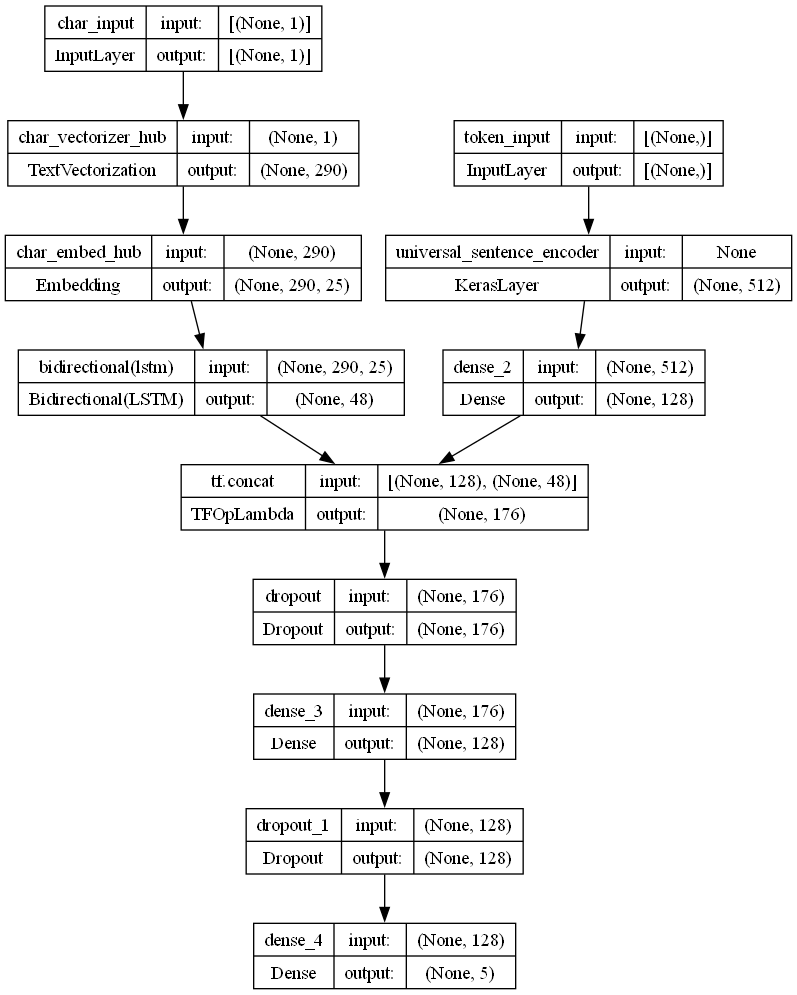

In [92]:
tf_keras.utils.plot_model(model_4, show_shapes = True, show_layer_names = True)

In [93]:
# Compiles hybrid model (token - char model)
model_4.compile(loss = "categorical_crossentropy", 
                optimizer = tf_keras.optimizers.Adam(), 
                metrics = ["accuracy"])

#### Turning data into Tensorflow Datasets to allow fitting of hybrid model run faster

In [94]:
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars)) # makes data
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) # makes lables
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels)) # combines data and labels

# Prefetches and batch train data.
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Repeats same steps for validation data.
val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars))
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels))
val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_char_token_data, val_char_token_data

(<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.string, name=None))>,
 <_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.string, name=None))>)

#### Fitting a model on token and char dataset

In [95]:
histoty_model_4 = model_4.fit(train_char_token_dataset, 
                              steps_per_epoch= int(0.1 * len(train_char_token_dataset)),
                              epochs = 3, 
                              validation_data = val_char_token_dataset, 
                              validation_steps = int(0.1 * len(val_char_token_dataset)))

Epoch 1/3
562/562 [==============================] - 53s 84ms/step - loss: 0.9900 - accuracy: 0.6065 - val_loss: 0.7958 - val_accuracy: 0.6918
Epoch 2/3
562/562 [==============================] - 46s 82ms/step - loss: 0.8045 - accuracy: 0.6888 - val_loss: 0.7238 - val_accuracy: 0.7231
Epoch 3/3
562/562 [==============================] - 45s 80ms/step - loss: 0.7746 - accuracy: 0.7030 - val_loss: 0.6954 - val_accuracy: 0.7367


In [96]:
# Evaluates on whole validation dataset.
model_4.evaluate(val_char_token_dataset)

945/945 [==============================] - 19s 20ms/step - loss: 0.6956 - accuracy: 0.7358


[0.6955814361572266, 0.735833466053009]

In [97]:
# Making prediction on model_4.
model_4_pred_probs = model_4.predict(val_char_token_dataset)
model_4_pred_probs, model_4_pred_probs.shape

945/945 [==============================] - 21s 20ms/step


(array([[4.1741911e-01, 3.6654550e-01, 3.7499811e-03, 2.0422877e-01,
         8.0566937e-03],
        [3.3932257e-01, 5.2386266e-01, 3.3307022e-03, 1.3045928e-01,
         3.0247367e-03],
        [2.6378298e-01, 1.5898125e-01, 3.7997261e-02, 5.0187755e-01,
         3.7361000e-02],
        ...,
        [4.5841804e-04, 5.5405176e-03, 7.5232238e-02, 1.5509510e-04,
         9.1861373e-01],
        [6.7920885e-03, 5.2476518e-02, 2.2547147e-01, 2.8785716e-03,
         7.1238136e-01],
        [2.7667996e-01, 4.8257756e-01, 1.7747448e-01, 2.3673913e-02,
         3.9594103e-02]], dtype=float32),
 (30212, 5))

In [98]:
# Converting predictions' propabilietes to classes.
model_4_preds = tf.argmax(model_4_pred_probs, axis = 1)
model_4_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 1], dtype=int64)>

In [99]:
# Calculating model_4 results.
model_4_results = hf.calculate_results(y_true = val_labels_encoded,
                                       y_pred = model_4_preds)
model_4_results

{'accuracy': 73.5833443664769,
 'precision': 0.7374367725592845,
 'recall': 0.735833443664769,
 'f1': 0.7338771194450197}

In [100]:
# Compares the baseline model against to model_4.
hf.compare_baseline_to_new_model_results(baseline_results, model_4_results)

The "accuracy" of new model '73.58', is BETTER than baseline's '72.18' => 1.40.

The "precision" of new model '0.74', is BETTER than baseline's '0.72' => 0.02.

The "recall" of new model '0.74', is BETTER than baseline's '0.72' => 0.01.

The "f1" of new model '0.73', is BETTER than baseline's '0.70' => 0.03.



### Model 5: Transfer Learning with pretrained token embeddings + character embeddings + positional embeddings

In [101]:
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


#### Creating positional embeddings

In [102]:
# How many different line numbers are there ?
train_df["line_number"].value_counts()

line_number
0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: count, dtype: int64

<Axes: ylabel='Frequency'>

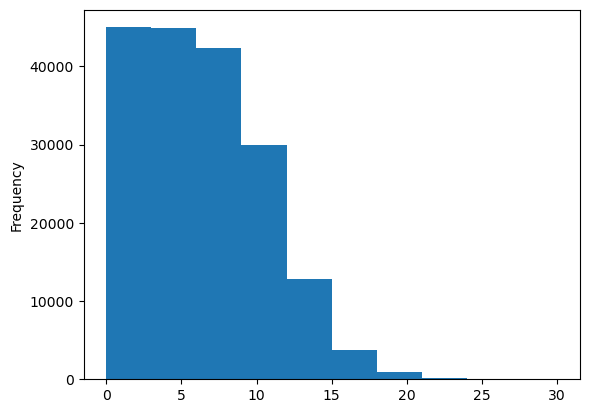

In [103]:
# Checking the distribution of "line_number" column
train_df.line_number.plot.hist()

In [104]:
# Using TensorFlow to create one-hot-encoded tensors of our "line_number" column.
train_line_numbers_one_hot = tf.one_hot(train_df["line_number"].to_numpy(), depth = 15)
val_line_numbers_one_hot = tf.one_hot(val_df["line_number"].to_numpy(), depth = 15)
test_line_numbers_one_hot = tf.one_hot(test_df["line_number"].to_numpy(), depth = 15)

In [105]:
train_line_numbers_one_hot[:14], train_line_numbers_one_hot.shape

(<tf.Tensor: shape=(14, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0.

In [106]:
# How many different numbers of lines are there?
train_df["total_lines"].value_counts()

total_lines
11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: count, dtype: int64

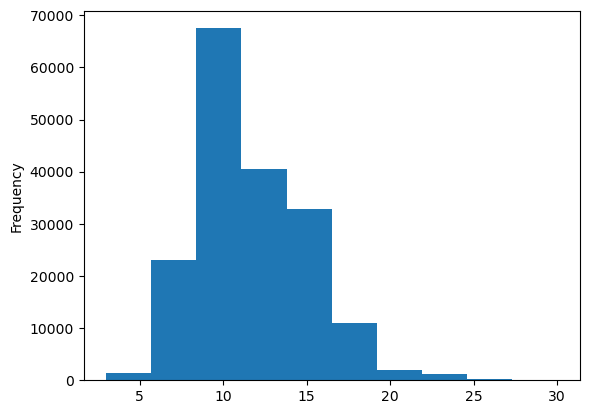

In [107]:
# Check the distribution of total lines
train_df.total_lines.plot.hist();

In [108]:
# Looking for the best number of total_lines, based on 98% of occurencies.
best_total_line_num = int(np.percentile(train_df.total_lines, 98))
best_total_line_num

20

In [109]:
# Using TensorFlow to create one-hot-encoded tensors of our "total_lines" column.
train_total_lines_one_hot = tf.one_hot(train_df["total_lines"].to_numpy(), depth = best_total_line_num)
val_total_lines_one_hot = tf.one_hot(val_df["total_lines"].to_numpy(), depth = best_total_line_num)
test_total_lines_one_hot = tf.one_hot(test_df["total_lines"].to_numpy(), depth = best_total_line_num)

In [110]:
# Checking the shape and samples of total lines one-hot tensor.
train_total_lines_one_hot.shape, train_total_lines_one_hot[:10]

(TensorShape([180040, 20]),
 <tf.Tensor: shape=(10, 20), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0

#### Building a hybrid embedding model, being a combined version of 3 models

In [111]:
# 1. Token inputs.
token_inputs = tf_keras.layers.Input(shape = [], dtype = "string", name = "token_inputs")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = tf_keras.layers.Dense(128, activation = "relu")(token_embeddings)
token_model = tf_keras.Model(inputs = token_inputs, outputs = token_outputs)

# 2. Char inputs.
char_inputs = tf_keras.layers.Input(shape = (1, ), dtype = "string", name = "char_inputs")
char_vectors_hub = char_vectorizer_hub(char_inputs)
char_embeddings_hub = char_embed_hub(char_vectors_hub)
char_bi_lstm = tf_keras.layers.Bidirectional(tf_keras.layers.LSTM(32))(char_embeddings_hub)
char_model = tf_keras.Model(inputs = char_inputs, outputs = char_bi_lstm)

# 3. Line numbers inputs.
line_number_inputs = tf_keras.layers.Input(shape = (15, ), dtype = tf.float32, name = "line_number_input")
x = tf_keras.layers.Dense(32, activation = "relu")(line_number_inputs)
line_number_model = tf_keras.Model(inputs = line_number_inputs, outputs = x)

# 4. Total lines inputs.
total_lines_inputs = tf_keras.layers.Input(shape = (20, ), dtype = tf.float32, name = "total_lines_input")
y = tf_keras.layers.Dense(32, activation = "relu")(total_lines_inputs)
total_lines_model = tf_keras.Model(inputs = total_lines_inputs, outputs = y)

# 5. Combines token and char embeddings into a hybrid embedding.
combined_embeddings  = tf_keras.layers.Concatenate(name = "token_char_hybrid_embedding")([token_model.output, char_model.output])
z = tf_keras.layers.Dense(256, activation = "relu")(combined_embeddings)
z = tf_keras.layers.Dropout(0.5)(z)

# 6. Combines positional embeddings with combined token and char embeddings into a tribrid embedding.
z = tf_keras.layers.Concatenate(name = "token_char_positional_embedding")([line_number_model.output, total_lines_model.output, z])

# 7. Creates output layer.
output_layer = tf_keras.layers.Dense(5, activation = "softmax", name = "output_layer")(z)


# 8. Puts together model.
model_5 = tf_keras.Model(inputs = [line_number_model.input,
                                   total_lines_model.input,
                                   token_model.input, 
                                   char_model.input],
                         outputs = output_layer)

In [112]:
model_5.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 char_inputs (InputLayer)    [(None, 1)]                  0         []                            
                                                                                                  
 token_inputs (InputLayer)   [(None,)]                    0         []                            
                                                                                                  
 char_vectorizer_hub (TextV  (None, 290)                  0         ['char_inputs[0][0]']         
 ectorization)                                                                                    
                                                                                                  
 universal_sentence_encoder  (None, 512)                  2567978   ['token_inputs[0][0]']  

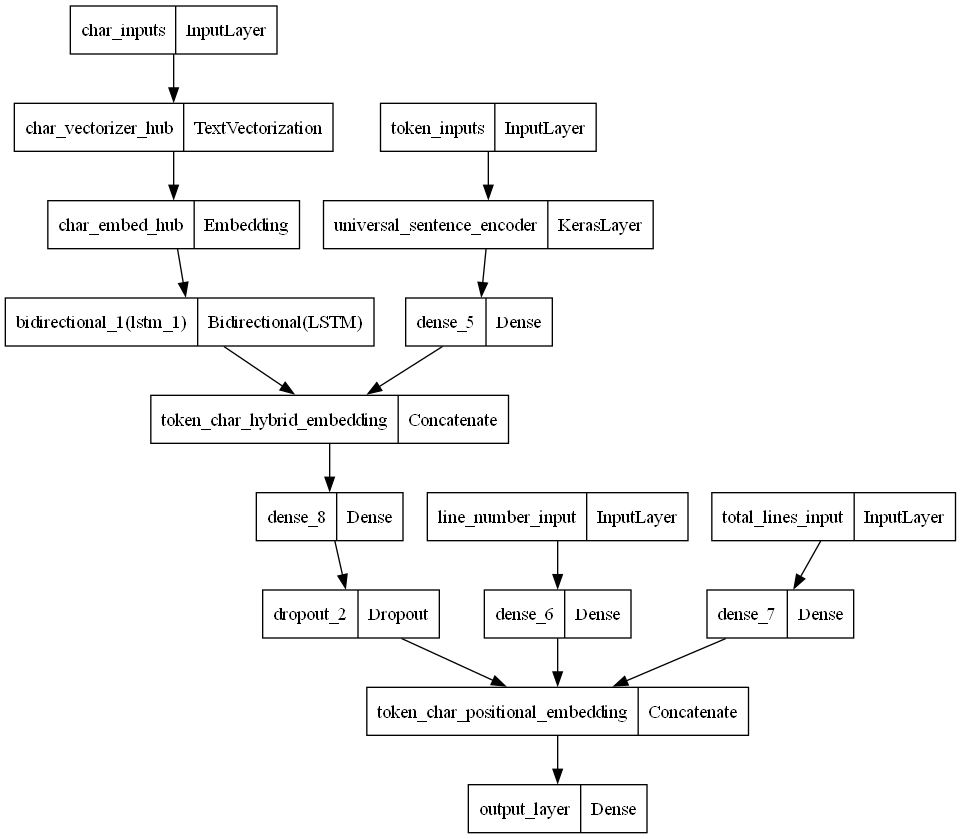

In [113]:
# tf_keras.utils.plot_model(model_5, show_shapes = True, show_layer_names = True)
tf_keras.utils.plot_model(model_5)

In [114]:
# Compiles hybrid model (token - char model)
model_5.compile(loss = tf_keras.losses.CategoricalCrossentropy(label_smoothing = 0.2), # helps to prevent overfitting 
                optimizer = tf_keras.optimizers.Adam(), 
                metrics = ["accuracy"])

#### Creating tribrid embedding datasets using tf.data

In [115]:
# Creates training and validation datasets (all four kinds of inputs)
train_pos_char_token_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot, # line numbers
                                                                train_total_lines_one_hot, # total lines
                                                                train_sentences, # train tokens
                                                                train_chars)) # train chars
train_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) # train labels

train_pos_char_token_dataset = tf.data.Dataset.zip((train_pos_char_token_data, train_pos_char_token_labels)) # combines data and labels
train_pos_char_token_dataset = train_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) # turns into batches and prefetch appropriately

# Validation dataset.
val_pos_char_token_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,
                                                              val_total_lines_one_hot,
                                                              val_sentences,
                                                              val_chars))
val_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)

val_pos_char_token_dataset = tf.data.Dataset.zip((val_pos_char_token_data, val_pos_char_token_labels))
val_pos_char_token_dataset = val_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) # turns into batches and prefetch appropriately

In [116]:
# Checking the shape and samples of total lines one-hot tensor.
train_pos_char_token_dataset, val_pos_char_token_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

#### Fitting a tribrid model on token and char

In [117]:
histoty_model_5 = model_5.fit(train_pos_char_token_dataset,
                              steps_per_epoch = int(0.1 * len(train_pos_char_token_dataset)),
                              epochs = 3, 
                              validation_data = val_pos_char_token_dataset, 
                              validation_steps = int(0.1 * len(val_pos_char_token_dataset)))

Epoch 1/3
562/562 [==============================] - 54s 85ms/step - loss: 1.0957 - accuracy: 0.7232 - val_loss: 0.9803 - val_accuracy: 0.8052
Epoch 2/3
562/562 [==============================] - 46s 82ms/step - loss: 0.9671 - accuracy: 0.8158 - val_loss: 0.9496 - val_accuracy: 0.8275
Epoch 3/3
562/562 [==============================] - 46s 83ms/step - loss: 0.9503 - accuracy: 0.8225 - val_loss: 0.9397 - val_accuracy: 0.8265


In [118]:
# Evaluates on whole validation dataset.
model_5.evaluate(val_pos_char_token_dataset)

945/945 [==============================] - 22s 23ms/step - loss: 0.9368 - accuracy: 0.8332


[0.936846137046814, 0.833245038986206]

In [119]:
# Making prediction on model_5.
model_5_pred_probs = model_5.predict(val_pos_char_token_dataset)
model_5_pred_probs, model_5_pred_probs.shape

945/945 [==============================] - 24s 23ms/step


(array([[0.49877894, 0.1234269 , 0.01312155, 0.3450742 , 0.01959842],
        [0.5303693 , 0.09915446, 0.04227255, 0.3166665 , 0.01153718],
        [0.2687449 , 0.10858025, 0.1640611 , 0.38579452, 0.07281922],
        ...,
        [0.0311601 , 0.10964399, 0.04651861, 0.02875758, 0.78391963],
        [0.02767937, 0.33074063, 0.09942935, 0.02277793, 0.5193727 ],
        [0.23849903, 0.54353297, 0.09284737, 0.04351163, 0.08160909]],
       dtype=float32),
 (30212, 5))

In [120]:
# Converting predictions' propabilietes to classes.
model_5_preds = tf.argmax(model_5_pred_probs, axis = 1)
model_5_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 1], dtype=int64)>

In [121]:
# Calculating model_5 results.
model_5_results = hf.calculate_results(y_true = val_labels_encoded,
                                       y_pred = model_5_preds)
model_5_results

{'accuracy': 83.32450681848272,
 'precision': 0.8318757855794238,
 'recall': 0.8332450681848272,
 'f1': 0.8321399475450273}

In [122]:
# Compares the baseline model against to model_5.
hf.compare_baseline_to_new_model_results(baseline_results, model_5_results)

The "accuracy" of new model '83.32', is BETTER than baseline's '72.18' => 11.14.

The "precision" of new model '0.83', is BETTER than baseline's '0.72' => 0.11.

The "recall" of new model '0.83', is BETTER than baseline's '0.72' => 0.11.

The "f1" of new model '0.83', is BETTER than baseline's '0.70' => 0.13.



### Comparing all model results

In [123]:
all_model_results = pd.DataFrame({"model_0_baselint": baseline_results,
                                  "model_1_custom_token_embedding": model_1_results,
                                  "model_2_pretrained_token_embedding": model_2_results,
                                  "model_3_custom_char_embedding": model_3_results,
                                  "model_4_hybrid_char_token_embedding": model_4_results,
                                  "model_5_pos_char_token_embedding": model_5_results})
all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
model_0_baselint,72.183238,0.718647,0.721832,0.698925
model_1_custom_token_embedding,78.753475,0.783952,0.787535,0.785151
model_2_pretrained_token_embedding,78.753475,0.783952,0.787535,0.785151
model_3_custom_char_embedding,37.895538,0.396923,0.378955,0.297329
model_4_hybrid_char_token_embedding,73.583344,0.737437,0.735833,0.733877
model_5_pos_char_token_embedding,83.324507,0.831876,0.833245,0.832140


In [124]:
# Reduces the accuracy to same scale as other metrics.
all_model_results["accuracy"] = all_model_results["accuracy"]/100

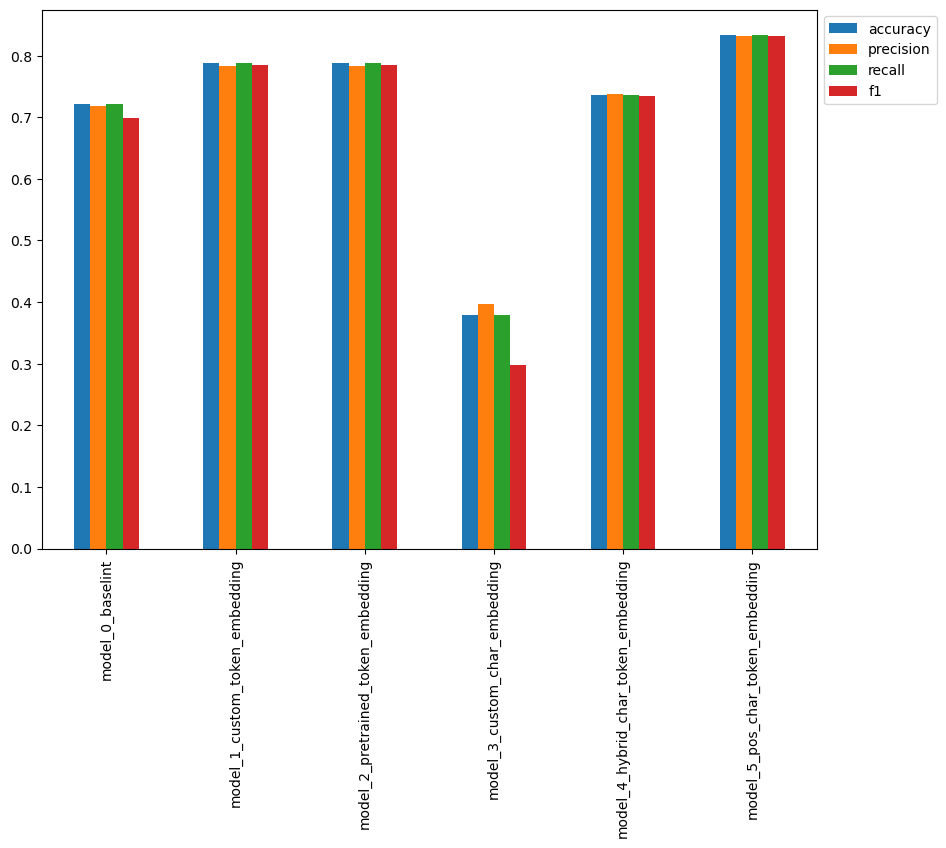

In [125]:
# Plotting and compare all model resutls.
all_model_results.plot(kind = "bar", figsize = (10, 7)).legend(bbox_to_anchor = (1.0, 1.0));

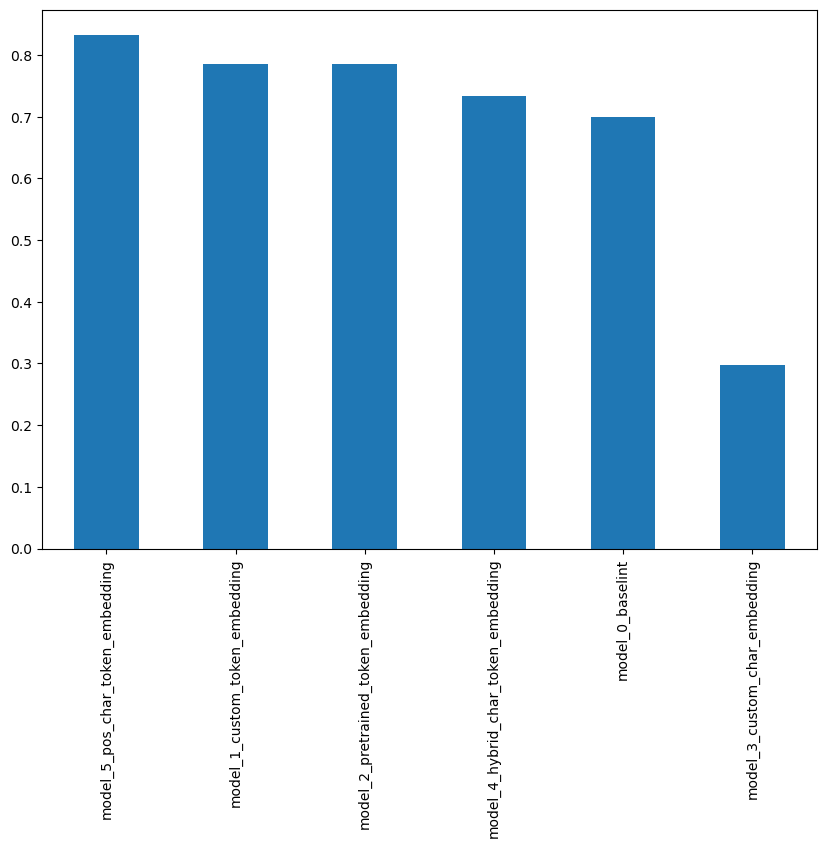

In [126]:
# Sorts model results by f1-score
all_model_results.sort_values("f1", ascending = False)["f1"].plot(kind = "bar", figsize = (10, 7));